In [1]:
from utils.task import get_input
from utils.analysis import get_attractors, plot_hiddens_and_data, get_speed, visualize_fixed_points, is_stable, get_all_hiddens, minimize_speed, get_all_hiddens
from utils.model import plot_behavior
from utils.utils import get_model

import torch

/Users/slibkind/opt/anaconda3/envs/multitask-rnn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def interpolate_input(task_idx, period, stimulus, tasks, n_interp, step_i):
    input1 = get_input(task_idx[0], period[0], stimulus[0], tasks)
    input2 = get_input(task_idx[1], period[1], stimulus[1], tasks)

    interpolated_input = (n_interp - step_i)/n_interp * input1 + (step_i/n_interp) * input2
    return interpolated_input

def find_fixed_points(rnn, tasks, input, learning_rate, grad_threshold):
    sample_proportion = 0.1   # proportion of all hidden states to be sampled

    # Load model and get initial conditions for finding fixed points
    all_hiddens = get_all_hiddens(rnn, tasks)

    # Determine the number of samples from the proportion of hidden states
    hidden_state_count = all_hiddens.size(0)
    num_samples = int(hidden_state_count * sample_proportion)  # Calculate the number of samples

    # Randomly permute the indices and select the first num_samples
    indices = torch.randperm(hidden_state_count)[:num_samples]  
    sampled_hiddens = all_hiddens[indices]  # Select the sampled hidden points using the sampled indices

    fps = minimize_speed(rnn, input, sampled_hiddens, learning_rate, grad_threshold, method='second')

    return fps


In [35]:
# Select a model

model_name = "delaygo_delayanti_255 copy"
rnn, tasks = get_model(model_name)#, epoch = '2000')

## Network behavior

Plot the behavior of the model on all input sequences for all tasks. Use larger period durations to test if the computation is time-independent.

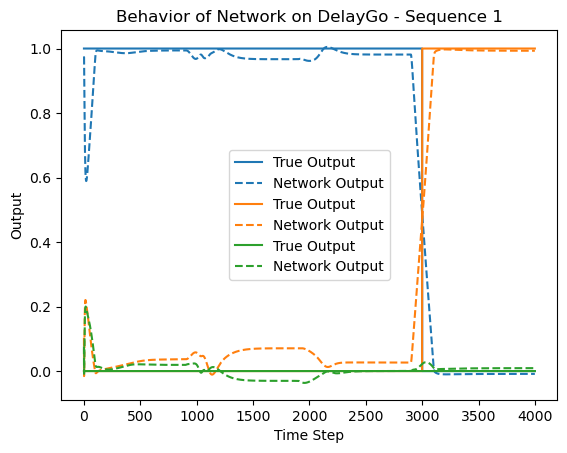

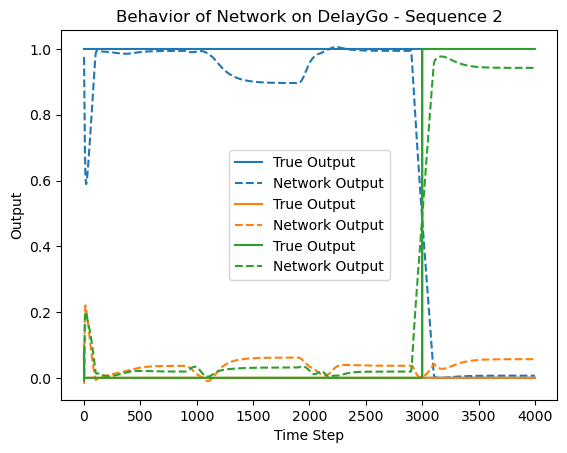

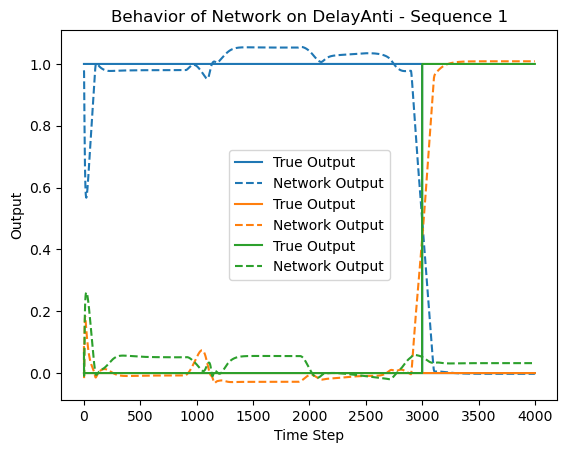

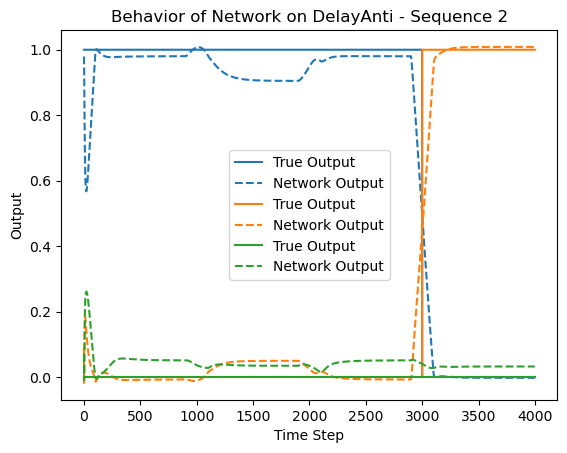

In [44]:
period_duration=1000
smoothing_window = int(period_duration * 0.2)
plot_behavior(rnn, tasks, period_duration=period_duration, smoothing_window=smoothing_window)

## Fixed points for a single input

In [37]:
# Set the input

interpolate = False    # Variable for interpolated vs. direct input

if not interpolate:
  # Parameters for input computed directly from task
  task_idx = 1
  period = "delay"
  stimulus = 2
  input = get_input(task_idx, period, stimulus, tasks)
  
else:
  # Paramters for interpolated input
  task_idx = [0,1]
  period = ["delay", "delay"]
  stimulus = [1, 1]
  n_interp = 20
  step_i = 10

  input = interpolate_input(task_idx, period, stimulus, tasks, n_interp, step_i)


print(f"The input is {input.numpy()}.")

The input is [1. 0. 0. 0. 1.].


In [38]:

# Parameters for finding fixed points
learning_rate = 0.1
grad_threshold = 1e-3

fps = find_fixed_points(rnn, tasks, input, learning_rate, grad_threshold)


unique_fps = get_unique_fixed_points(fps.detach()).detach()
print(f"There are {len(unique_fps)} unique fixed points.")

Iteration 0: maximum gradient norm across all initial conditions is 0.3176456689834595
Time taken for the last 10000 iterations: 0.09008002281188965 seconds.
Stopping optimization: maximum gradient norm across all initial conditions is below the threshold.
There are 2 unique fixed points.


In [43]:
speeds = get_speed(rnn, input, unique_fps.float())
for i, fp in enumerate(unique_fps):
    if is_stable(rnn, fp, input):
        stability = "stable"
    else:
        stability = "unstable"

    print(f"Fixed point {i} has speed {speeds[i]} and is {stability}")

Fixed point 0 has speed 0.0031257004011422396 and is unstable
Fixed point 1 has speed 0.003108995035290718 and is unstable
Fixed point 2 has speed 9.671216361084589e-08 and is stable
Fixed point 3 has speed 4.772774673256208e-07 and is stable
Fixed point 4 has speed 0.0031131852883845568 and is unstable
Fixed point 5 has speed 0.003108743578195572 and is stable
Fixed point 6 has speed 0.0031079170294106007 and is stable
Fixed point 7 has speed 0.003109217621386051 and is unstable
Fixed point 8 has speed 0.0031249946914613247 and is unstable
Fixed point 9 has speed 0.0031081149354577065 and is stable
Fixed point 10 has speed 1.193662910736748e-07 and is stable
Fixed point 11 has speed 0.003108748933300376 and is stable
Fixed point 12 has speed 0.003109532641246915 and is unstable
Fixed point 13 has speed 0.003114578314125538 and is unstable
Fixed point 14 has speed 0.0031092199496924877 and is unstable
Fixed point 15 has speed 0.0031104087829589844 and is unstable
Fixed point 16 has spe

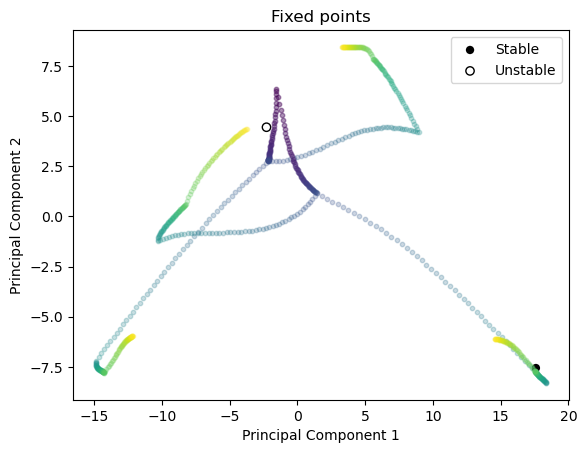

In [40]:
# Plot the fixed points

q_thresh = 1e-1

stable_fps = []
unstable_fps = []

for (i, fixed_point) in enumerate(unique_fps):
    if speeds[i] > q_thresh:
        continue
    if is_stable(rnn, fixed_point, input):
        stable_fps.append(fixed_point)
    else:
        unstable_fps.append(fixed_point)

# Prepare data lists
data_tensors = []
labels = []
fills = []

if stable_fps:  # if the list is not empty
    data_tensors.append(torch.stack(stable_fps))
    labels.append('Stable')
    fills.append(True)

if unstable_fps:  # if the list is not empty
    data_tensors.append(torch.stack(unstable_fps))
    labels.append('Unstable')
    fills.append(False)

# Plot only if we have any data to plot
if data_tensors:
    plot_hiddens_and_data(rnn, tasks, 
                          data_tensors, 
                          label_list = labels,
                          filled_list = fills,
                          title = "Fixed points")
else:
    print("No fixed points to plot.")

## Fixed points for interpolated inputs

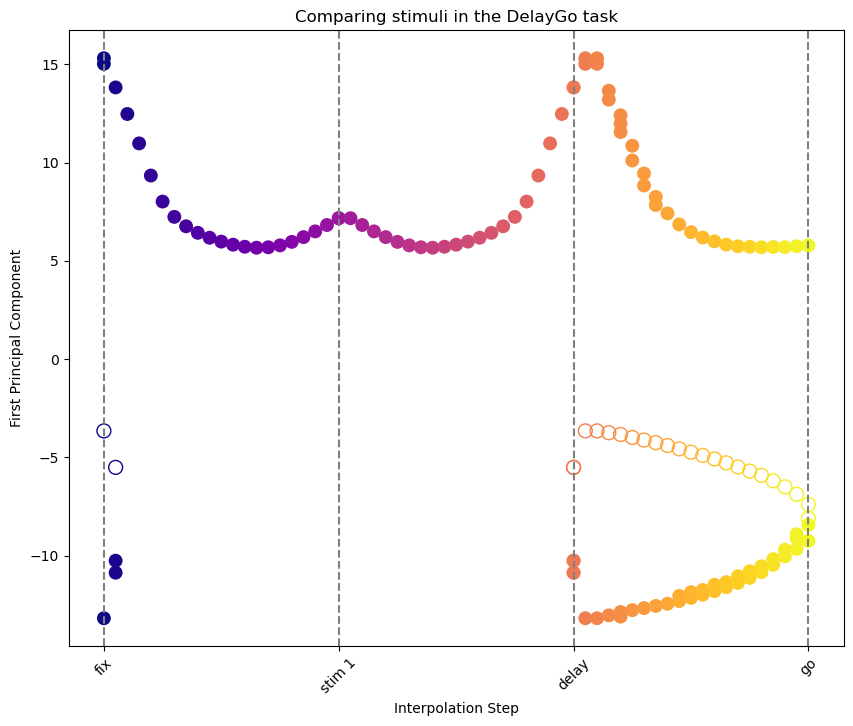

In [9]:
task_idx = [1, 1, 1, 1]
period = ["fix", "stim", "delay", "go"]
stimulus = [2, 2, 2, 2]
n_interp = 20
labels = ["fix", "stim 1" , "delay", "go"]
title = "Comparing stimuli in the DelayGo task"
q_thresh = None

visualize_fixed_points(model_name, task_idx, period, stimulus, n_interp, input_labels = labels, title = title, q_thresh=q_thresh)

## Attractors for a single input

It is also sometimes useful to find the attractors for a single input by running the network forwards and visualizing the points to which it converges. Unlike fixed point finder, this method can find attractors with more complex topologies. However, this method cannot be used to find unstable invariant sets. 

In [13]:
# Set the input

interpolate = False    # Variable for interpolated vs. direct input

if interpolate:
  # Paramters for interpolated input
  task_idx = [0,1]
  period = ["delay", "delay"]
  stimulus = [1, 1]
  n_interp = 20
  step_i = 3

  input = interpolate_input(task_idx, period, stimulus, tasks, n_interp, step_i)

else:
  # Parameters for input computed directly from task
  task_idx = 0
  period = "delay"
  stimulus = 1
  input = get_input(task_idx, period, stimulus, tasks)

print(f"The input is {input.numpy()}.")

The input is [1. 0. 0. 1. 0.].


In [10]:
all_hiddens = get_all_hiddens(rnn, tasks)
num_timesteps = 3000
num_last = 100

attractors = get_attractors(rnn, input, all_hiddens, num_timesteps, num_last)

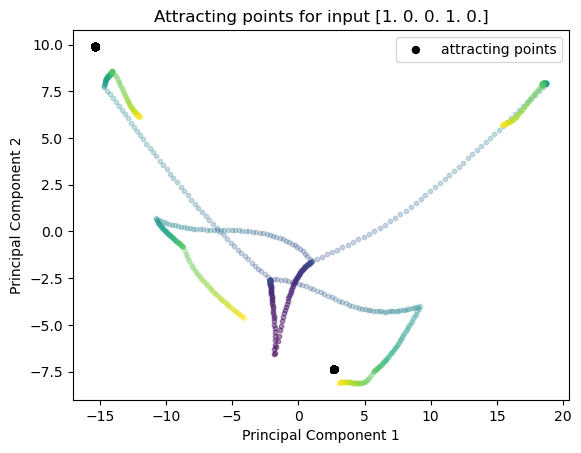

In [12]:
attractors = attractors.reshape(-1, attractors.shape[-1])
plot_hiddens_and_data(rnn, tasks, [attractors], 
                      label_list = ["attracting points"], 
                      title = f"Attracting points for input {input.numpy()}"
)